In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from regression import ridge_and_lasso, decision_trees, k_nearest_neighbors, linear_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import copy
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
def read_data(filepath, use_industry=False, replace_with_mean=False):
    data = pd.read_excel(filepath, sheet_name = "Data", headers = None)
    data = data.set_index('tic')
    data.columns = data.columns.map(str)

    

    print('Original data shape: ', data.shape)

    # del columns with all NAN
    data = data.dropna(axis=1, how='all')

    # sector and industry can't be aggregated, drop if NAN
    data = data[pd.notnull(data['Sector'])]

    if use_industry:
        data = data[pd.notnull(data['Industry'])]

    print('Data after removing NAN sectors, industries ', data.shape)
    

    if replace_with_mean: 
        # replace with mean values
        print("Replacing empty cells with column means")
        for col in data.columns.to_list():
            if col == 'Sector':
                continue
            elif use_industry and col == 'Industry':
                continue
            data[col].fillna(data[col].mean(), inplace=True)

    # del rows with any NAN 
    data = data.dropna()

    print("Final Data: ", data.shape)


    # delete future sales predictions
    del data['St+1']
    del data['St']

    # Convert ordinal Sector into one-hot vectors
    data = pd.concat([data,pd.get_dummies(data['Sector'], prefix='Sector',dummy_na=False)],axis=1).drop(['Sector'],axis=1)

    if use_industry:
        # Convert ordinal Sector into one-hot vectors
        data = pd.concat([data,pd.get_dummies(data['Industry'], prefix='Industry',dummy_na=False)],axis=1).drop(['Industry'],axis=1)
    else:
        del data['Industry']

    return data

filepath = "../Sample.2.xlsx"
data = read_data(filepath)
data.head()

Original data shape:  (2559, 55)
Data after removing NAN sectors, industries  (2396, 55)
Final Data:  (1634, 55)


,EMPLt,CPXt-1,GDWLt-1,GPt-1,OCFt-1,PPEt-1,RDt-1,SGAt-1,St-1,TEQt-1,...,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
tic,,,,,,,,,,,,,,,,,,,,,
A,16300.0,156000.0,3590000,2790000.0,1020000.0,850000.0,404000,1860000.0,5160000.0,4750000.0,...,0,0,0,0,0,1,0,0,0,0
AA,13800.0,379000.0,150000,1200000.0,686000.0,7920000.0,27000,307000.0,10500000.0,4110000.0,...,0,0,0,0,0,0,0,0,0,0
AAL,107400.0,4270000.0,4090000,11420000.0,3820000.0,43730000.0,0,2000000.0,45770000.0,-118000.0,...,0,0,0,0,0,0,1,0,0,0
AAN,12100.0,92960.0,736580,1730000.0,441570.0,566880.0,0,1170000.0,3950000.0,1740000.0,...,0,0,0,0,0,0,1,0,0,0
AAOI,3115.0,29430.0,0,45700.0,-858.0,256330.0,43400,94450.0,190870.0,273790.0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
def split_data(data, year):
    year_cols = ['EMPLt']

    for col in data.columns.to_list():
        if col.endswith(str(year)) or col.startswith('Sector') or col.startswith('Industry'):
            year_cols.append(col)

    # print(year, year_cols)
    year_df = data[year_cols].copy()
    year_df['Gt-' + str(year)] = data['St-' + str(year)] * 1.0 / data['St-' + str(year + 1)]
    print(year, year_df.columns.to_list())

    # delete sales from training data as output_var is Gt
    del year_df['St-'+ str(year)]
    return year_df

years = [1, 2, 3, 4]
# year = 1 means to predict Gt-1 (St-1/St-2)

all_df = {}
for year in years:
    all_df[year] = split_data(data, year)
    print(year, all_df[year].shape)

1 ['EMPLt', 'CPXt-1', 'GDWLt-1', 'GPt-1', 'OCFt-1', 'PPEt-1', 'RDt-1', 'SGAt-1', 'St-1', 'TEQt-1', 'TDt-1', 'Sector_Basic Materials', 'Sector_Communication Services', 'Sector_Consumer Cyclical', 'Sector_Consumer Defensive', 'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare', 'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities', 'Gt-1']
1 (1634, 22)
2 ['EMPLt', 'CPXt-2', 'GDWLt-2', 'GPt-2', 'OCFt-2', 'PPEt-2', 'RDt-2', 'SGAt-2', 'St-2', 'TEQt-2', 'TDt-2', 'Sector_Basic Materials', 'Sector_Communication Services', 'Sector_Consumer Cyclical', 'Sector_Consumer Defensive', 'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare', 'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities', 'Gt-2']
2 (1634, 22)
3 ['EMPLt', 'CPXt-3', 'GDWLt-3', 'GPt-3', 'OCFt-3', 'PPEt-3', 'RDt-3', 'SGAt-3', 'St-3', 'TEQt-3', 'TDt-3', 'Sector_Basic Materials', 'Sector_Communication Services', 'Sector_Consumer Cyclical', 'Sector_Con

In [4]:
all_df_list = []
for year in years:
    temp_df = all_df[year].copy(deep=True)
    all_df_list.append(temp_df)

first_year = 0
suffix_str = '1' # at end of col names
for i in range(1, len(all_df_list)):
    all_df_list[i].columns = all_df_list[first_year].columns


merged_df = pd.concat(all_df_list, ignore_index=False)
print('Size of merged dataset : ', merged_df.shape)

# year == 0 means merged dataset for all years, train a single model for all years
rename_columns = {}
for col in merged_df.columns.to_list():
    if col.endswith(suffix_str):
        newcol = col[:-1] + str(0)
        rename_columns[col] = newcol
merged_df.rename(columns=rename_columns, inplace=True)
all_df[0] = merged_df
years.append(0)

Size of merged dataset :  (6536, 22)


In [5]:
merged_df

,EMPLt,CPXt-0,GDWLt-0,GPt-0,OCFt-0,PPEt-0,RDt-0,SGAt-0,TEQt-0,TDt-0,...,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities,Gt-0
tic,,,,,,,,,,,,,,,,,,,,,
A,16300.0,156000.0,3590000,2790000.0,1020000.0,850000.0,404000,1860000.0,4750000.0,1790000,...,0,0,0,0,1,0,0,0,0,1.050916
AA,13800.0,379000.0,150000,1200000.0,686000.0,7920000.0,27000,307000.0,4110000.0,1961000,...,0,0,0,0,0,0,0,0,0,0.776627
AAL,107400.0,4270000.0,4090000,11420000.0,3820000.0,43730000.0,0,2000000.0,-118000.0,30590000,...,0,0,0,0,0,1,0,0,0,1.027616
AAN,12100.0,92960.0,736580,1730000.0,441570.0,566880.0,0,1170000.0,1740000.0,708410,...,0,0,0,0,0,1,0,0,0,1.031332
AAOI,3115.0,29430.0,0,45700.0,-858.0,256330.0,43400,94450.0,273790.0,108960,...,0,0,0,0,0,0,0,1,0,0.713613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIXI,566.0,2140.0,2160,49610.0,15250.0,3980.0,9550,40300.0,49070.0,0,...,0,0,0,0,0,0,0,1,0,1.099251
ZNGA,1883.0,10310.0,613340,502870.0,60020.0,269440.0,329300,603650.0,1580000.0,0,...,0,0,0,0,0,0,0,0,0,0.969531
ZS,2020.0,8170.0,0,98250.0,-6020.0,13140.0,33560,133320.0,57710.0,0,...,0,0,0,0,0,0,0,1,0,1.565044


## Regression Models

In [6]:
def prepare_data(X, year):
    X = X.reset_index()
    del X['tic']
    
    Y = X['Gt-' + str(year)]
    del X['Gt-' + str(year)]
    train_x, test_x, train_y, test_y = train_test_split(X, Y, shuffle=True, test_size=0.3, random_state=15)

    return train_x, train_y, test_x, test_y

In [7]:
scalers = {}

def standardize_data(train_x_df, train_y_df, test_x_df, test_y_df, year):
    # Requires numpy array for cross-validation in regression.py
    train_x = train_x_df.to_numpy()
    test_x = test_x_df.to_numpy()
    train_y = train_y_df.to_numpy()
    test_y = test_y_df.to_numpy()

    print('Train=', train_x.shape)
    print('Test=', test_x.shape)

    # normalize and scale data attributes
    # use only train_x for fitting
    # don't normalize, scale output variable

    scaler = preprocessing.MinMaxScaler().fit(train_x)

    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    # to be used later for query
    scalers[year] = scaler
    return train_x, train_y, test_x, test_y


In [8]:
train_x_dfs = {}
train_y_dfs = {}
test_x_dfs = {}
test_y_dfs = {}

train_xs = {}
train_ys = {}
test_xs = {}
test_ys= {}

for year in years:
    print('Preparing data for year: ', year)
    print(all_df[year].columns.to_list())
    train_x_dfs[year], train_y_dfs[year], test_x_dfs[year], test_y_dfs[year] = prepare_data(all_df[year], year)
    train_xs[year], train_ys[year], test_xs[year], test_ys[year] = standardize_data(train_x_dfs[year], train_y_dfs[year], test_x_dfs[year], test_y_dfs[year], year)

Preparing data for year:  1
['EMPLt', 'CPXt-1', 'GDWLt-1', 'GPt-1', 'OCFt-1', 'PPEt-1', 'RDt-1', 'SGAt-1', 'TEQt-1', 'TDt-1', 'Sector_Basic Materials', 'Sector_Communication Services', 'Sector_Consumer Cyclical', 'Sector_Consumer Defensive', 'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare', 'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities', 'Gt-1']
Train= (1143, 21)
Test= (491, 21)
Preparing data for year:  2
['EMPLt', 'CPXt-2', 'GDWLt-2', 'GPt-2', 'OCFt-2', 'PPEt-2', 'RDt-2', 'SGAt-2', 'TEQt-2', 'TDt-2', 'Sector_Basic Materials', 'Sector_Communication Services', 'Sector_Consumer Cyclical', 'Sector_Consumer Defensive', 'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare', 'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities', 'Gt-2']
Train= (1143, 21)
Test= (491, 21)
Preparing data for year:  3
['EMPLt', 'CPXt-3', 'GDWLt-3', 'GPt-3', 'OCFt-3', 'PPEt-3', 'RDt-3', 'SGAt-3', 'TEQt-3', 'TDt-3', 'S

### Feature Selection

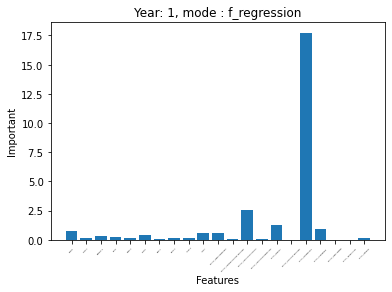

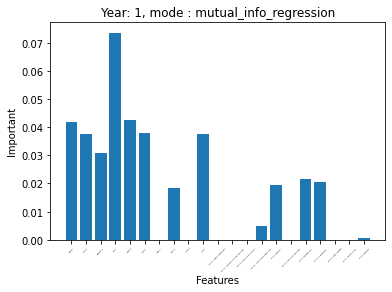

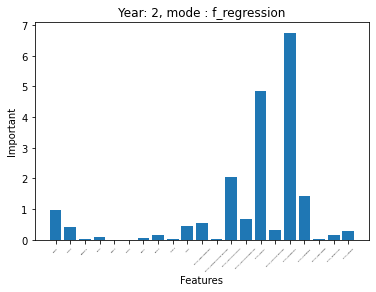

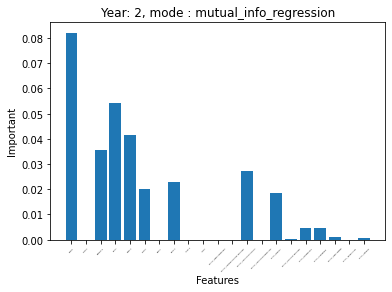

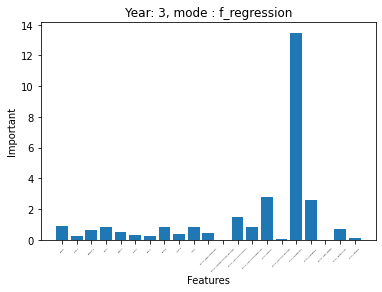

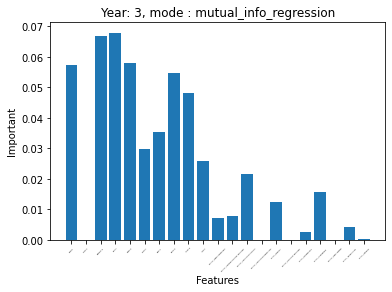

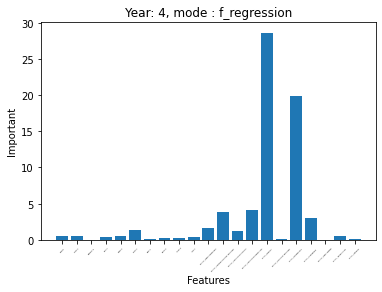

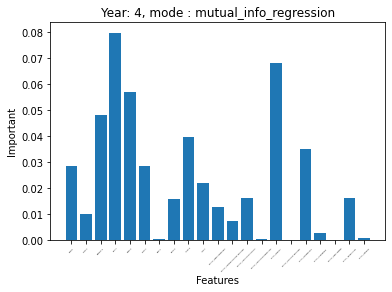

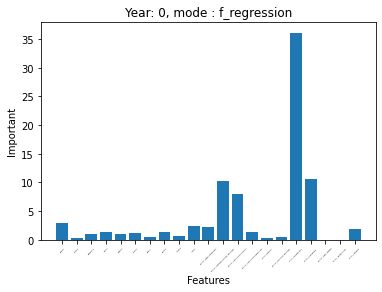

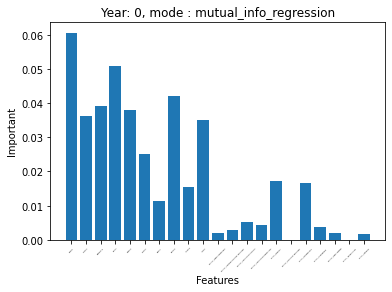

In [9]:
# feature selection
def select_features(X_train, y_train, X_test, mode):
    # configure to select all features
    if mode == 'f_regression':
        fs = SelectKBest(score_func=f_regression, k='all')
    elif mode == 'mutual_info_regression':
        fs = SelectKBest(score_func=mutual_info_regression, k='all')
    # learn relationship from training data
    X_train = X_train.astype(np.float64)
    y_train = y_train.astype(np.float64)
    X_test = X_test.astype(np.float64)
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

modes = ['f_regression', 'mutual_info_regression']
for year in years:
    for mode in modes:
        # feature selection
        X_train_fs, X_test_fs, fs = select_features(train_x_dfs[year], train_y_dfs[year], test_x_dfs[year], mode)

        # what are scores for the features
        # for i in range(len(fs.scores_)):
        # 	print('Feature %d: %f' % (i, fs.scores_[i]))

        # plot the scores
        columns = train_x_dfs[year].columns.to_list()
        pyplot.xticks(rotation = (45), fontsize = 2)
        pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_, tick_label=columns)
        pyplot.xlabel("Features")
        pyplot.ylabel("Important")
        pyplot.title("Year: {}, mode : {}".format(year, mode))
        pyplot.show()

### Regression Model

In [10]:
# Compute MAE
def compute_error(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

# Compute MSE
def compute_MSE(y, y_hat):
    # mean squared error
    return np.mean(np.power(y - y_hat, 2))

In [11]:
predicted_y  = {}
dt_model = {}
knn_model = {}
lr_model = {}
lm_model = {}

for year in years:
    metrics = ['mae', 'mse']
    models = ['dt', 'knn', 'lm', 'lr']
    print("\n")
    print("+++++++++++++")
    print("year: " + str(year))
    print("+++++++++++++")
    print(train_xs[year].shape, train_ys[year].shape, test_xs[year].shape)
    for model in models:
        if model == 'dt':
            predicted_y[year], dt_model[year] = decision_trees('A', train_xs[year], train_ys[year], test_xs[year])
        elif model =='knn':
            predicted_y[year], knn_model[year] = k_nearest_neighbors('A', train_xs[year], train_ys[year], test_xs[year])
        elif model =='lr':
            predicted_y[year], lr_model[year] = linear_regression('A', train_xs[year], train_ys[year], test_xs[year])
        elif model == 'lm':
            predicted_y[year], lm_model[year] = ridge_and_lasso('data', train_xs[year], train_ys[year], test_xs[year])
            
        for metric in metrics:
            if metric == 'mae':
                print('For year {}, MAE on test set: {:0.4f}'.format(str(year), compute_error(predicted_y[year], test_ys[year])))
            elif metric == 'mse':
                print('For year {}, MSE on test set: {:0.4f}'.format(str(year), compute_MSE(predicted_y[year], test_ys[year])))



+++++++++++++
year: 1
+++++++++++++
(1143, 21) (1143,) (491, 21)
Running decision tree regressor for data type: A
After cross-val, best depth for data A is 3 with mean Error: 0.1663
Training model on full data
For year 1, MAE on test set: 0.1359
For year 1, MSE on test set: 0.0663
Running k-nearest neighbor regressor for data type: A
After cross-val, best neighbors for data A is 25 with mean Error: 0.1864
Training model on full data
For year 1, MAE on test set: 0.1519
For year 1, MSE on test set: 0.0677
Running ridge regressors for data type: data
Running lasso regressors for data type: data
After cross-val, best method for data data is lasso with alpha = 0.01 and mean Error: 0.1795
Training model on full data
For year 1, MAE on test set: 0.1495
For year 1, MSE on test set: 0.0629
Running linear regression for data type: A
After cross-val for data A mean Error: 19071535243.3709
Training model on full data
For year 1, MAE on test set: 0.1544
For year 1, MSE on test set: 0.0643


+++++

In [12]:
# print('Printing Predictions')
# for y_hat, y in zip(predicted_y, test_y):
#     print(y, y_hat)

### Feature Importance based on learned regressor

In [18]:
for year in years:
    print("\n")
    print("+++++++++++++")
    print("year: " + str(year))
    print("+++++++++++++")
    for model in [dt_model[year], lr_model[year], lm_model[year]]:
        print('\nModel : ', model)
        
        model_select = SelectFromModel(model, prefit=True)
        train_x_df_new = model_select.transform(train_x_dfs[year])
        print(train_x_dfs[year].shape, train_x_df_new.shape)

        feature_idx = model_select.get_support()
        feature_name = train_x_dfs[year].columns[feature_idx]
        print("Important Features: " ,feature_name)



+++++++++++++
year: 1
+++++++++++++

Model :  DecisionTreeRegressor(criterion='mae', max_depth=3)
(1143, 21) (1143, 6)
Important Features:  Index(['EMPLt', 'GPt-1', 'OCFt-1', 'PPEt-1', 'RDt-1', 'TEQt-1'], dtype='object')

Model :  LinearRegression()
(1143, 21) (1143, 7)
Important Features:  Index(['EMPLt', 'CPXt-1', 'GPt-1', 'OCFt-1', 'PPEt-1', 'TEQt-1', 'TDt-1'], dtype='object')

Model :  Lasso(alpha=0.01)
(1143, 21) (1143, 1)
Important Features:  Index(['Sector_Healthcare'], dtype='object')


+++++++++++++
year: 2
+++++++++++++

Model :  DecisionTreeRegressor(criterion='mae', max_depth=3)
(1143, 21) (1143, 4)
Important Features:  Index(['EMPLt', 'GDWLt-2', 'GPt-2', 'Sector_Energy'], dtype='object')

Model :  LinearRegression()
(1143, 21) (1143, 11)
Important Features:  Index(['Sector_Basic Materials', 'Sector_Communication Services',
       'Sector_Consumer Cyclical', 'Sector_Consumer Defensive',
       'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare',
       'Sect

In [14]:
# Using all_cmp_data (train + test) and standardize it
year = 1
query = 'TSLA'
all_cmp_data = all_df[year].copy(deep=True)
# remove output var
del all_cmp_data['Gt-'+str(year)]

### Get Nearest Neighbors using KNN

In [15]:
print('All data size', all_cmp_data.shape)
this_data = all_cmp_data.loc[query].to_numpy().reshape(1, -1)
this_data = scalers[year].transform(this_data)


# ensure this is same as in prepare data -- can get indices in train
train_x, _ = train_test_split(all_cmp_data, shuffle=True, test_size=0.3, random_state=15)
train_x = train_x.reset_index()
all_train_tics = train_x['tic']

# returns index in the training set
neighbors = knn_model[year].kneighbors(this_data, n_neighbors=5, return_distance=False)

print('Neigbors are: ')
for n in neighbors[0]:
    print('Company close to {} is {}'.format(query, all_train_tics[n]))

All data size (1634, 21)
Neigbors are: 
Company close to TSLA is TSLA
Company close to TSLA is GT
Company close to TSLA is WYNN
Company close to TSLA is NCLH
Company close to TSLA is LB


### Clustering

In [16]:
cluster_data = copy.deepcopy(all_cmp_data)
cluster_data = cluster_data.reset_index()
del cluster_data['tic']
X_embedded = TSNE(n_components=2).fit_transform(cluster_data)
print('reduced shape', X_embedded.shape)

reduced shape (1634, 2)


<AxesSubplot:>

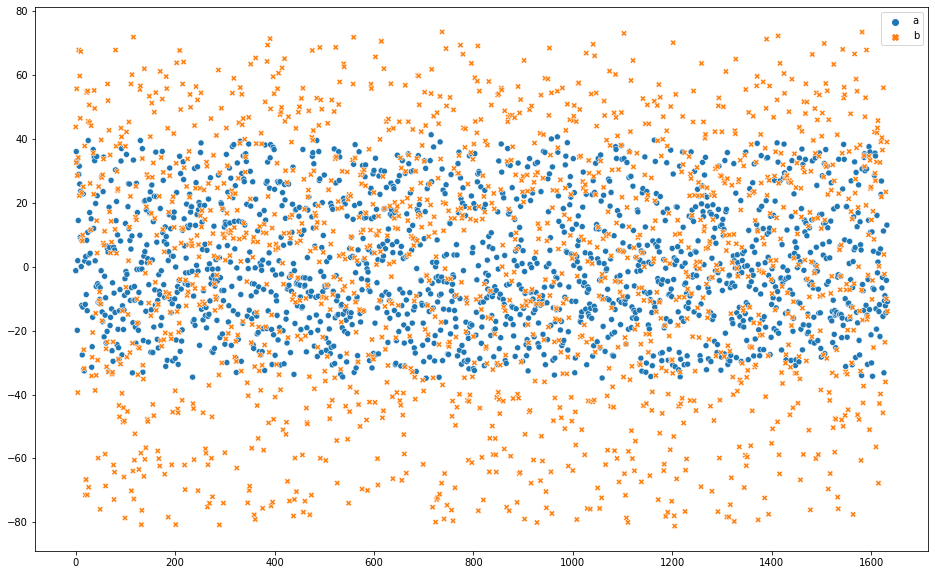

In [17]:
df = pd.DataFrame()
df['a'] = X_embedded[:,0]
df['b'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    data=df)